# Pre-processing DineSafe Data, Performing Exploratory Data Analysis, and Creating the Final Dataframe

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType, MapType

# spark session
spark = SparkSession \
    .builder \
    .appName("Yelp and DineSafe Toronto") \
    .getOrCreate()
sc = spark.sparkContext

In [2]:
# Dinesafe from Open Data Toronto: https://open.toronto.ca/dataset/dinesafe/
from pyspark.sql.functions import explode
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType, MapType, DoubleType, FloatType, LongType
from pyspark.sql.functions import col, trim, upper, lower

# Read xml file from dineSafe and save it as json file
#                 *COMMENTED to save time*
# import json
# import xmltodict 
# with open("ds.xml") as xml_file:
#     data_dict = xmltodict.parse(xml_file.read())
#     xml_file.close() 
      
    # generate the object using json.dumps()  
    # corresponding to json data 
      
#     json_data = json.dumps(data_dict) 
      
#     # Write the json data to output  
#     # json file 
#     with open("dineSafe.json", "w") as json_file: 
#         json_file.write(json_data) 
#         json_file.close() 

In [3]:
# Schema for DineSafe data (not necessary at this stage)
schemaDineSafe = StructType([
    StructField('DINESAFE_DATA',
                StructType([
                    StructField('ESTABLISHMENT',ArrayType(
                        StructType([
                            StructField('ADDRESS',StringType(),True),
                            StructField('ID',StringType(),True),
                            StructField('INSPECTION',StringType(),True),
                            StructField('LATITUDE',StringType(),True), #tried to read as floatype and doubletype but failed
                            StructField('LONGITUDE',StringType(),True),
                            StructField('NAME',StringType(),True),
                            StructField('STATUS',StringType(),True),
                            StructField('TYPE',StringType(),True)
                                    ]),True),True)
                            ]),True)
])

# Read DineSafe data in json format
dineSafe = spark.read.json('dineSafe.json', schema = schemaDineSafe)
dineSafe = dineSafe.select(explode("DINESAFE_DATA.ESTABLISHMENT"))
dineSafe = dineSafe.select(col("col.ADDRESS").alias("ds_address"), 
                           col("col.ID").alias("ds_id"), 
                           col("col.LATITUDE").alias("ds_latitude"), 
                           col("col.LONGITUDE").alias("ds_longitude"), \
                           col("col.NAME").alias("ds_name"), 
                           col("col.STATUS").alias("ds_status"), 
                           col("col.TYPE").alias("ds_type"), 
                           col("col.INSPECTION").alias("ds_inspection"))

# convert ds_latitude and ds_longitude to float type
dineSafe = dineSafe.withColumn('ds_latitude',dineSafe['ds_latitude'].cast("double"))
dineSafe = dineSafe.withColumn('ds_longitude',dineSafe['ds_longitude'].cast("double"))

# lowercase and trim ds_ds_address; filter out records with no ds_ds_address
dineSafe = dineSafe.withColumn("ds_address", lower(dineSafe["ds_address"]))
dineSafe = dineSafe.withColumn("ds_address", trim(dineSafe["ds_address"]))
dineSafe = dineSafe.filter(dineSafe.ds_address != "")

# lowercase and trim ds_name; filter out records with no ds_name
dineSafe = dineSafe.withColumn("ds_name", lower(dineSafe["ds_name"]))
dineSafe = dineSafe.withColumn("ds_name", trim(dineSafe["ds_name"]))
dineSafe = dineSafe.filter(dineSafe.ds_name != "")

In [4]:
# Explore dineSafe data
dineSafe.show(10, truncate=False)
dineSafe.printSchema()
print("There are {} businesses in DineSafe - Toronto".format(dineSafe.count()))

+-----------------------+--------+-----------+------------+------------------------+---------+--------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## EDA on DineSafe Dataset

### 1. Distribution of Pass vs. No Pass

In [4]:
# import required libraries/packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.sql import SQLContext

In [6]:
dineSafe.select("ds_status").show(10)
dineSafe_pass = dineSafe[dineSafe['ds_status']=='Pass'].count() #17617
dineSafe_nopass = dineSafe[dineSafe['ds_status']!='Pass'].count() #27

+---------+
|ds_status|
+---------+
|     Pass|
|     Pass|
|     Pass|
|     Pass|
|     Pass|
|     Pass|
|     Pass|
|     Pass|
|     Pass|
|     Pass|
+---------+
only showing top 10 rows



Since the number of establishments that passed vs. did not pass are just two different counts from our dataset, we can illustrate their distribution using a simple pie chart.

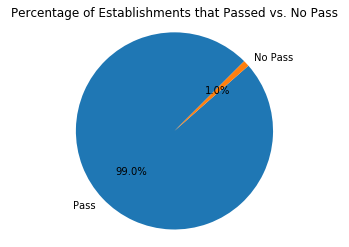

In [7]:
# Explore establishments that passed vs. no pass
dineSafe_pass_nopass_piechart_labels = 'Pass', 'No Pass'
sizes = [99, 1]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=dineSafe_pass_nopass_piechart_labels, autopct='%1.1f%%',
        shadow=False, startangle=45)
ax1.axis('equal') 
plt.title('Percentage of Establishments that Passed vs. No Pass')
plt.show()

The vast majority of establishments passed their inspections. Out of 17,644 establishments, approximately 99% of them passed their inspection, while the other 1%, or 27 establishments, did not. This may indicate that whether or not an establishment passed their inspection would not be a very meaningful predictor when trying to fit our model.

We will now examine the types of establishments that passed vs. didn't pass:

Text(0.5, 1.0, 'Distribution of Establishments that Did Not Pass Inspection')

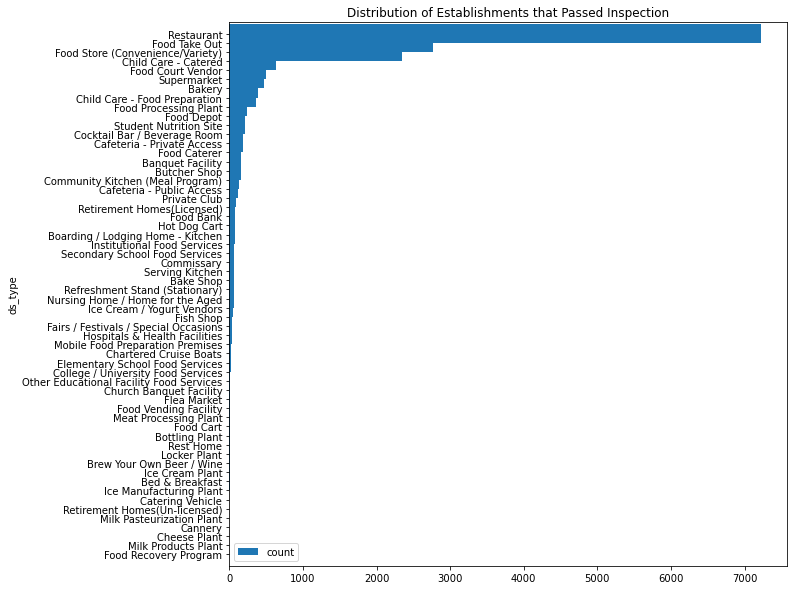

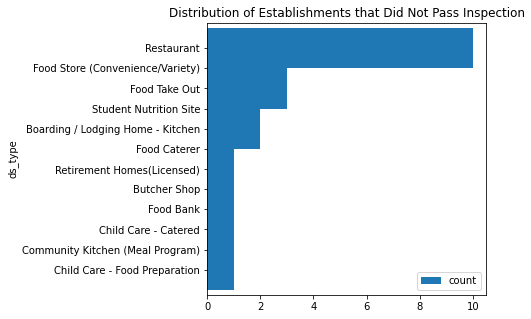

In [5]:
# Examine types of establishments by pass vs. no pass
dineSafe_type_of_establishment_nopass = dineSafe[dineSafe['ds_status']!='Pass']
dineSafe_type_of_establishment_nopass_labels = dineSafe_type_of_establishment_nopass.distinct()
dineSafe_type_of_establishment_hist_nopass=dineSafe_type_of_establishment_nopass.groupBy('ds_type').count().orderBy("count") #.show()
dineSafe_type_of_establishment_hist_nopass = dineSafe_type_of_establishment_hist_nopass.toPandas()

dineSafe_type_of_establishment_pass = dineSafe[dineSafe['ds_status']=='Pass']
dineSafe_type_of_establishment_pass_labels = dineSafe_type_of_establishment_pass.distinct()
dineSafe_type_of_establishment_hist_pass=dineSafe_type_of_establishment_pass.groupBy('ds_type').count().orderBy("count") #.show()
dineSafe_type_of_establishment_hist_pass = dineSafe_type_of_establishment_hist_pass.toPandas()

# Plot horizontal barplot of distribution of establishments that passed inspection
ax_pass = dineSafe_type_of_establishment_hist_pass.plot.barh(x='ds_type', y='count',width=2,figsize=(10,10))
ax_pass.set_title('Distribution of Establishments that Passed Inspection')

# Plot horizontal barplot of distribution of establishments that did not pass inspection
ax_nopass = dineSafe_type_of_establishment_hist_nopass.plot.barh(x='ds_type', y='count',width=2,figsize=(5,5))
ax_nopass.set_title('Distribution of Establishments that Did Not Pass Inspection')

### 2. Distribution of Establishment Type

In [9]:
print('There are {} unique establishment types in the DineSafe dataset.'.format(dineSafe.select("ds_type").distinct().count()))

There are 58 unique establishment types in the DineSafe dataset.


With 58 unique establishment types in our dataset, we're going to construct a plot that shows the proportion of each establishment in our dataset.

Text(0.5, 1.0, 'Distribution of Establishment Type')

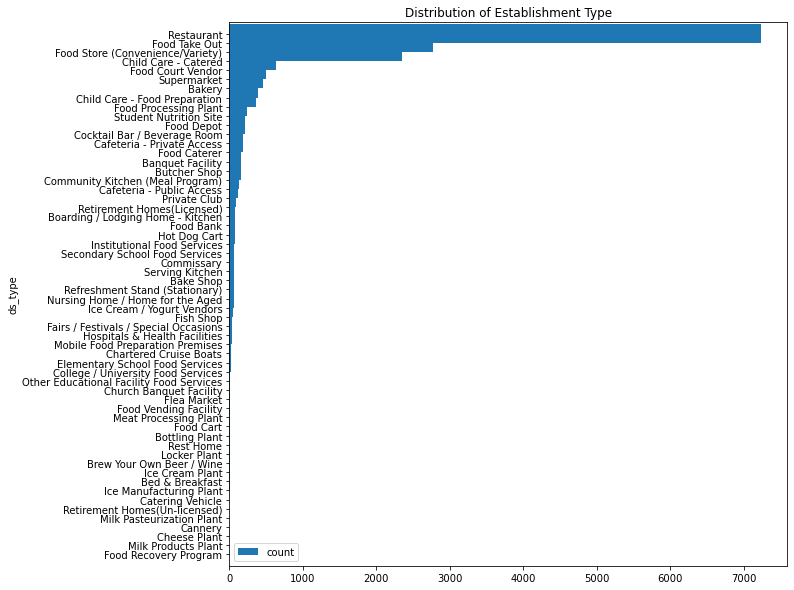

In [30]:
# Examine establishment types
dineSafe_type_of_establishment = dineSafe.select('ds_type')
dineSafe_type_of_establishment_labels = dineSafe.select("ds_type").distinct()

dineSafe_type_of_establishment_hist=dineSafe_type_of_establishment.groupBy('ds_type').count().orderBy("count") #.show()
dineSafe_type_of_establishment_hist = dineSafe_type_of_establishment_hist.toPandas()

ax2 = dineSafe_type_of_establishment_hist.plot.barh(x='ds_type', y='count',width=2,figsize=(10,10))
ax2.set_title('Distribution of Establishment Type')

As you can see from the bar plot, the majority of the establishments from the DineSafe dataset are classified as either "Restaurant", "Food Take Out", and "Food Store". If we zoom in on the plot, we can get a better look at the distribution of the less common establishments:

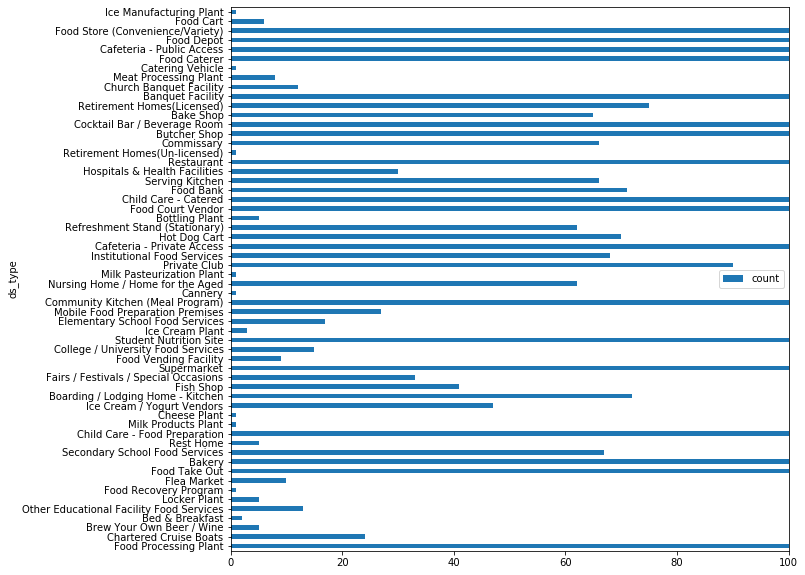

In [11]:
# Examine less common establishment types
ax3 = dineSafe_type_of_establishment_hist.plot.barh(x='ds_type', y='count',width=0.5,figsize=(10,10),
                                                   xlim=[0,100])

### 3. Distribution of Establishments with Infractions and/or Inspections

In [12]:
print('There are {} entries in the inspection column.'.format(dineSafe.select(['ds_inspection']).count()))

There are 17644 entries in the inspection column.


We are going to split the inspection list into four different categories: 
* establishments with an infraction who received an inspection
* establishments with an infraction who did not receive an inspection
* establishments with no infraction who recieved an inspection
* establishments with no infraction who did not receieve an inspection

In [7]:
# create dineSafe by presence of infraction or not and by either one or multiple infractions
dineSafe_Infraction =  dineSafe.filter(dineSafe.ds_inspection.contains("INFRACTION"))
dineSafe_Inspectionlist = dineSafe.filter(dineSafe.ds_inspection.contains("["))

dineSafe_Infraction_InspectionList =  dineSafe_Infraction.intersect(dineSafe_Inspectionlist)
dineSafe_Infraction_NoInspectionList = dineSafe_Infraction.subtract(dineSafe_Inspectionlist)

dineSafe_NoInfraction =  dineSafe.subtract(dineSafe_Infraction)

dineSafe_NoInfraction_InspectionList = dineSafe_NoInfraction.intersect(dineSafe_Inspectionlist)
dineSafe_NoInfraction_NoInspectionList = dineSafe_NoInfraction.subtract(dineSafe_NoInfraction_InspectionList)

In [8]:
#dineSafe_Infraction_InspectionList.count() #9318
#dineSafe_Infraction_NoInspectionList.count() #665
#dineSafe_NoInfraction_InspectionList.count() #3326
#dineSafe_NoInfraction_NoInspectionList.count() #4435

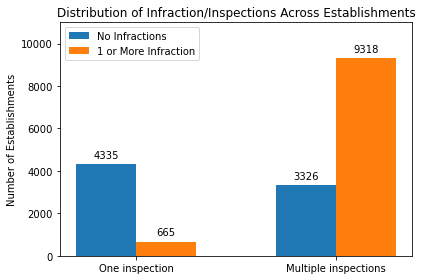

In [27]:
# create bargraph of distribution for each category
labels = ['One inspection', 'Multiple inspections']
noInfractionLabels = [dineSafe_NoInfraction_NoInspectionList.count(), dineSafe_NoInfraction_InspectionList.count()]
InfractionLabels = [dineSafe_Infraction_NoInspectionList.count(), dineSafe_Infraction_InspectionList.count()]

x = np.arange(len(labels))  # the label locations
width = 0.30  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, noInfractionLabels, width, label='No Infractions')
rects2 = ax.bar(x + width/2, InfractionLabels, width, label='1 or More Infraction')
ax.set_ylabel('Number of Establishments')
ax.set_title('Distribution of Infraction/Inspections Across Establishments')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 4),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
figsize=(5,5)
plt.ylim(0, 11000)     
plt.savefig('figs/dist_InfrInsp_AllEstablishments.png')
plt.show()

As we can see from the plot above, for the establishments that did not recieve an inspection, about 87% of them had no infractions, while the remaining 13% of them had an infraction, but never receieved an inspection (which is strange, because it would seem like establishments would need to be inspected before being able to recieve an infraction). Additionally, for the establishments that recieved an inspection, approximately 74% of them had 1 or more infractions, while the remaining 26% had none. 

We can interpret these statistics in multiple ways, depending on the logistics behind inspections/infractions. For example, if an establishment needed to be inspected in order to get an infraction, then the 665 establishments who have infractions, but no inspections may be wrongly reported data. On the other hand, if a business needed an infraction from an outside source before an inspection was warranted, then the graph would make more sense, and the 665 establishments would have simply been wrongly accused of an infraction.

Now we are going to take a closer look at the 3 most common establishment types, and what proportion of infractions/inspections they make up.

In [16]:
# Examine most common establishment types
# sort list of establishments by number of entries and pull top 3 out
dineSafe_type_of_establishment_hist.sort_values(by='count',ascending=False)[0:3]

,ds_type,count
41,Restaurant,7230
8,Food Take Out,2771
55,Food Store (Convenience/Variety),2346


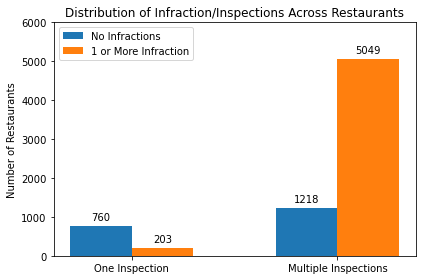

In [29]:
# Distribution for restaurant

# create 1 dataframe for each combination of infraction/inspection, and only count the entries for "restaurant" establishment type
dineSafe_noInfraction_noInspection_restaurant = dineSafe_NoInfraction_NoInspectionList[dineSafe_NoInfraction_NoInspectionList['ds_type']=='Restaurant'].count()
dineSafe_noInfraction_Inspection_restaurant = dineSafe_NoInfraction_InspectionList[dineSafe_NoInfraction_InspectionList['ds_type']=='Restaurant'].count()
dineSafe_Infraction_noInspection_restaurant = dineSafe_Infraction_NoInspectionList[dineSafe_Infraction_NoInspectionList['ds_type']=='Restaurant'].count()
dineSafe_Infraction_Inspection_restaurant = dineSafe_Infraction_InspectionList[dineSafe_Infraction_InspectionList['ds_type']=='Restaurant'].count()

# visualize the distribution of establishment infractions/inspections for restaurants only
labels = ['One Inspection', 'Multiple Inspections']
noInfractionLabels_restaurant = [dineSafe_noInfraction_noInspection_restaurant, dineSafe_noInfraction_Inspection_restaurant]
InfractionLabels_restaurant = [dineSafe_Infraction_noInspection_restaurant, dineSafe_Infraction_Inspection_restaurant]

x = np.arange(len(labels))  # the label locations
width = 0.30  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, noInfractionLabels_restaurant, width, label='No Infractions')
rects2 = ax.bar(x + width/2, InfractionLabels_restaurant, width, label='1 or More Infraction')
ax.set_ylabel('Number of Restaurants')
ax.set_title('Distribution of Infraction/Inspections Across Restaurants')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
figsize=(5,5)
plt.ylim(0, 6000)     
plt.savefig('figs/dist_InfrInsp_Restaurants.png')
plt.show()

This distribution of restaurants that fall into the 4 categories closely follows the distribution across all establishments. This may tell us that restaurants will be a strong predictor of other information. Additionally, this makes sense considering "restaurant" makes up roughly 41% of all establishments recorded.

Now we will do the same for "Food Take Out":

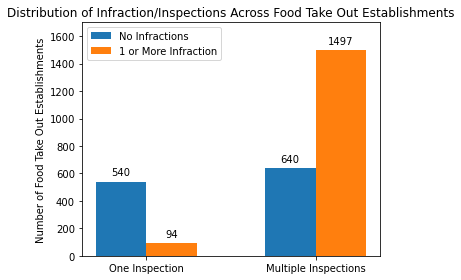

In [28]:
# Distribution for food take out

# create 1 dataframe for each combination of infraction/inspection, and only count the entries for "food take out" establishment type
dineSafe_noInfraction_noInspection_ftakeout = dineSafe_NoInfraction_NoInspectionList[dineSafe_NoInfraction_NoInspectionList['ds_type']=='Food Take Out'].count()
dineSafe_noInfraction_Inspection_ftakeout = dineSafe_NoInfraction_InspectionList[dineSafe_NoInfraction_InspectionList['ds_type']=='Food Take Out'].count()
dineSafe_Infraction_noInspection_ftakeout = dineSafe_Infraction_NoInspectionList[dineSafe_Infraction_NoInspectionList['ds_type']=='Food Take Out'].count()
dineSafe_Infraction_Inspection_ftakeout = dineSafe_Infraction_InspectionList[dineSafe_Infraction_InspectionList['ds_type']=='Food Take Out'].count()

# visualize the distribution of establishment infractions/inspections for food take out only
labels = ['One Inspection', 'Multiple Inspections']
noInfractionLabels_ftakeout = [dineSafe_noInfraction_noInspection_ftakeout, dineSafe_noInfraction_Inspection_ftakeout]
InfractionLabels_ftakeout = [dineSafe_Infraction_noInspection_ftakeout, dineSafe_Infraction_Inspection_ftakeout]

x = np.arange(len(labels))  # the label locations
width = 0.30  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, noInfractionLabels_ftakeout, width, label='No Infractions')
rects2 = ax.bar(x + width/2, InfractionLabels_ftakeout, width, label='1 or More Infraction')
ax.set_ylabel('Number of Food Take Out Establishments')
ax.set_title('Distribution of Infraction/Inspections Across Food Take Out Establishments')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
figsize=(5,5)
plt.ylim(0, 1700)     
plt.savefig('figs/dist_InfrInsp_TakeOut.png')
plt.show()

Similarly, we see that the distribution of infractions/inspections on food take out establishments follow a similar distribution to the distribution across all establishments. Food take out establishments account for approximately 16% of all recorded establishments.

Lastly, we will plot the distribution of infractions/inspections for food stores (convienience/variety):

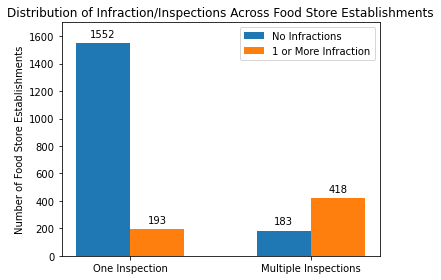

In [25]:
# Distribution for Food Store (Convienience/Variety)

# create 1 dataframe for each combination of infraction/inspection, and only count the entries for "food store" establishment type
dineSafe_noInfraction_noInspection_fstore = dineSafe_NoInfraction_NoInspectionList[dineSafe_NoInfraction_NoInspectionList['ds_type']=='Food Store (Convenience/Variety)'].count()
dineSafe_noInfraction_Inspection_fstore = dineSafe_NoInfraction_InspectionList[dineSafe_NoInfraction_InspectionList['ds_type']=='Food Store (Convenience/Variety)'].count()
dineSafe_Infraction_noInspection_fstore = dineSafe_Infraction_NoInspectionList[dineSafe_Infraction_NoInspectionList['ds_type']=='Food Store (Convenience/Variety)'].count()
dineSafe_Infraction_Inspection_fstore = dineSafe_Infraction_InspectionList[dineSafe_Infraction_InspectionList['ds_type']=='Food Store (Convenience/Variety)'].count()

# visualize the distribution of establishment infractions/inspections for food take out only
labels = ['One Inspection', 'Multiple Inspections']
noInfractionLabels_fstore = [dineSafe_noInfraction_noInspection_fstore, dineSafe_noInfraction_Inspection_fstore]
InfractionLabels_fstore = [dineSafe_Infraction_noInspection_fstore, dineSafe_Infraction_Inspection_fstore]

x = np.arange(len(labels))  # the label locations
width = 0.30  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, noInfractionLabels_fstore, width, label='No Infractions')
rects2 = ax.bar(x + width/2, InfractionLabels_fstore, width, label='1 or More Infraction')
ax.set_ylabel('Number of Food Store Establishments')
ax.set_title('Distribution of Infraction/Inspections Across Food Store Establishments')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
figsize=(5,5)
plt.ylim(0, 1700)     
plt.savefig('figs/dist_InfrInsp_FoodStore.png')
plt.show()

Looking at the distribution of infractions/inspections across food store establishments, we can see that roughly 75% of them did not recieve an infraction or inspection. However, out of the remaining 25% who received inspections, approximately 70% of them recieved 1 or more infractions. This is interesting, because it doesn't quite follow what we saw in the distribution across all establishments, and might indicate that food store establishments aren't a good predictor. Furthermore, food store establishments make up 13% of all establishments.

## Create Inspection Dataframes

### 1. No infractions and no inspections

In [20]:
# Create dataframe
import json
dineSafe_NoInfraction_NoInspectionList_RDD = dineSafe_NoInfraction_NoInspectionList.select("ds_id","ds_inspection"). \
                                                filter(col("ds_inspection").isNotNull()).rdd. \
                                                map(lambda x: '{"ds_id":"' + x[0] + '", ' + x[1] + "}"). \
                                                map(lambda x: x.replace('}}','}')). \
                                                map(lambda x: x.replace('{"STATUS','"STATUS')) . \
                                                map(lambda x: json.loads(x))

schema1 = StructType([ StructField('ds_id',StringType(),True),
                                    StructField('STATUS',StringType(),True),
                                    StructField('DATE',StringType(),True),
                                 ])

dineSafe_NoInfraction_NoInspectionList_DF = spark.read.json(dineSafe_NoInfraction_NoInspectionList_RDD, schema = schema1)

In [21]:
# inspect dataframe
dineSafe_NoInfraction_NoInspectionList_DF.printSchema()
dineSafe_NoInfraction_NoInspectionList_DF.show(10)
dineSafe_NoInfraction_NoInspectionList_DF.groupBy('STATUS').count().show()
dineSafe_NoInfraction_NoInspectionList_DF.count()

root
 |-- ds_id: string (nullable = true)
 |-- STATUS: string (nullable = true)
 |-- DATE: string (nullable = true)

+--------+------+----------+
|   ds_id|STATUS|      DATE|
+--------+------+----------+
|10362913|  Pass|2019-12-04|
|10196816|  Pass|2018-12-27|
|10331811|  Pass|2019-07-10|
|10709846|  Pass|2020-07-28|
|10714648|  Pass|2020-09-14|
|10702457|  Pass|2020-03-13|
|10573542|  Pass|2019-01-16|
|10285005|  Pass|2018-12-10|
|10328139|  Pass|2019-02-22|
|10659149|  Pass|2019-01-10|
+--------+------+----------+
only showing top 10 rows

+------+-----+
|STATUS|count|
+------+-----+
|  Pass| 2920|
+------+-----+



2920

### 2. Inspection with no infraction

In [22]:
# Create dataframe
dineSafe_NoInfraction_InspectionList_RDD = dineSafe_NoInfraction_InspectionList.select("ds_id","ds_inspection"). \
                                                filter(col("ds_inspection").isNotNull()).rdd. \
                                                map(lambda x: '{"ds_id":"' + x[0] + '", "ds_inspection":' + x[1] + "}"). \
                                                map(lambda x: json.loads(x))
dineSafe_NoInfraction_InspectionList_DF = spark.read.json(dineSafe_NoInfraction_InspectionList_RDD)
dineSafe_NoInfraction_InspectionList_DF = dineSafe_NoInfraction_InspectionList_DF.select("ds_id",explode("ds_inspection")).select("ds_id","col.DATE","col.STATUS")

In [23]:
# inspect dataframe
dineSafe_NoInfraction_InspectionList_DF.printSchema()
dineSafe_NoInfraction_InspectionList_DF.show(10)
dineSafe_NoInfraction_InspectionList_DF.groupBy('STATUS').count().show()
dineSafe_NoInfraction_InspectionList_DF.count()

root
 |-- ds_id: string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- STATUS: string (nullable = true)

+--------+----------+------+
|   ds_id|      DATE|STATUS|
+--------+----------+------+
|10620902|2019-01-15|  Pass|
|10620902|2019-07-11|  Pass|
|10570671|2018-11-20|  Pass|
|10570671|2019-07-03|  Pass|
|10398536|2019-04-12|  Pass|
|10398536|2019-09-30|  Pass|
|10325846|2018-11-13|  Pass|
|10325846|2019-05-01|  Pass|
|10325846|2020-01-22|  Pass|
| 9005515|2018-12-06|  Pass|
+--------+----------+------+
only showing top 10 rows

+------+-----+
|STATUS|count|
+------+-----+
|  Pass| 8869|
+------+-----+



8869

### 3. Infractions and no inspections

In [24]:
# Create dataframe
from pyspark.sql import Window
from pyspark.sql.functions import substring, length, col, expr, when, concat, lit
import pyspark.sql.functions as F

dineSafe_Infraction_NoInspectionList_RDD = dineSafe_Infraction_NoInspectionList.select("ds_id","ds_inspection"). \
                                                withColumn('ds_inspection',F.regexp_replace('ds_inspection',',"CONVICTION_DATE":null','')). \
                                                withColumn('ds_inspection',F.regexp_replace('ds_inspection',',"COURT_OUTCOME":null','')). \
                                                withColumn('ds_inspection',F.regexp_replace('ds_inspection',',"AMOUNT_FINED":null','')). \
                                                filter(col("ds_inspection").isNotNull()).rdd. \
                                                map(lambda x: '{"ds_id":"' + x[0] + '",' + x[1] + "}"). \
                                                map(lambda x: x.replace('"INFRACTION":{','')). \
                                                map(lambda x: x.replace('}}}','}')). \
                                                map(lambda x: x.replace('{"STATUS','"STATUS'))
dineSafe_Infraction_NoInspectionList_DF = spark.read.json(dineSafe_Infraction_NoInspectionList_RDD)

In [25]:
# inspect dataframe
dineSafe_Infraction_NoInspectionList_DF.printSchema()
dineSafe_Infraction_NoInspectionList_DF.show(10, truncate=False)
dineSafe_Infraction_NoInspectionList_DF.groupBy('STATUS').count().show()
dineSafe_Infraction_NoInspectionList_DF.count()

root
 |-- ACTION: string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- SEVERITY: string (nullable = true)
 |-- STATUS: string (nullable = true)
 |-- ds_id: string (nullable = true)

+---------------------------+----------+-------------------+------+--------+
|ACTION                     |DATE      |SEVERITY           |STATUS|ds_id   |
+---------------------------+----------+-------------------+------+--------+
|Notice to Comply           |2019-12-13|M - Minor          |Pass  |10695155|
|Notice to Comply           |2019-05-17|NA - Not Applicable|Pass  |10550393|
|Corrected During Inspection|2020-09-18|S - Significant    |Pass  |10715174|
|Notice to Comply           |2019-12-02|NA - Not Applicable|Pass  |10694059|
|Notice to Comply           |2019-10-30|NA - Not Applicable|Pass  |10632726|
|Notice to Comply           |2019-04-09|M - Minor          |Pass  |10550530|
|Notice to Comply           |2019-11-21|NA - Not Applicable|Pass  |10693270|
|Notice to Comply           |2019-0

665

### 4. Inspections with Infractions

In [26]:
windowByID = Window.partitionBy('ds_id')
dineSafe_Infraction_Inspectionlist_RDD = dineSafe_Infraction_InspectionList. \
                                            filter(col("ds_inspection").isNotNull()). \
                                            withColumn('ds_inspection',F.regexp_replace('ds_inspection',',"CONVICTION_DATE":null','')). \
                                            withColumn('ds_inspection',F.regexp_replace('ds_inspection',',"COURT_OUTCOME":null','')). \
                                            withColumn('ds_inspection',F.regexp_replace('ds_inspection',',"AMOUNT_FINED":null','')). \
                                            select("ds_id", F.split("ds_inspection", '"STATUS":').alias("ds_inspection"),
                                                    F.posexplode(F.split("ds_inspection", '"STATUS":')).alias("pos_ins","val_ins")).\
                                            withColumn('max_pos_ins', F.max('pos_ins').over(windowByID)). \
                                            filter(col('pos_ins') != 0).withColumn("val_ins", F.concat(F.lit('{"STATUS":'),col("val_ins"))). \
                                            withColumn('val_ins',expr("substring(val_ins,1,length(val_ins)-2)")). \
                                            withColumn('val_ins', when(col('pos_ins') == col('max_pos_ins'), concat(col('val_ins'), lit('}')))
                                                                      .otherwise(col('val_ins')))

# Divide into one inspection or multiple inspection records
dineSafe_Infraction_Inspectionlist_Infraction = dineSafe_Infraction_Inspectionlist_RDD.filter(dineSafe_Infraction_Inspectionlist_RDD.val_ins.contains('INFRACTION'))
dineSafe_Infraction_Inspectionlist_NoInfraction = dineSafe_Infraction_Inspectionlist_RDD.subtract(dineSafe_Infraction_Inspectionlist_Infraction)

In [27]:
dineSafe_Infraction_Inspectionlist_Infraction.printSchema()
dineSafe_Infraction_Inspectionlist_Infraction.select('ds_id','pos_ins','val_ins').show(5, truncate=False)

root
 |-- ds_id: string (nullable = true)
 |-- ds_inspection: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- pos_ins: integer (nullable = false)
 |-- val_ins: string (nullable = true)
 |-- max_pos_ins: integer (nullable = true)

+--------+-------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ds_id   |pos_ins|val_ins                                                                                                                                                                                                                                                                                                   |
+--------+-------+---------------------------------------------------------------------------------------

In [28]:
dineSafe_Infraction_Inspectionlist_NoInfraction.printSchema()
dineSafe_Infraction_Inspectionlist_NoInfraction.select('ds_id','pos_ins','val_ins').show(10, truncate=False)

root
 |-- ds_id: string (nullable = true)
 |-- ds_inspection: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- pos_ins: integer (nullable = false)
 |-- val_ins: string (nullable = true)
 |-- max_pos_ins: integer (nullable = true)

+--------+-------+-------------------------------------+
|ds_id   |pos_ins|val_ins                              |
+--------+-------+-------------------------------------+
|10225109|1      |{"STATUS":"Pass","DATE":"2019-02-27"}|
|10251386|1      |{"STATUS":"Pass","DATE":"2019-03-15"}|
|10285460|2      |{"STATUS":"Pass","DATE":"2019-04-08"}|
|10285460|5      |{"STATUS":"Pass","DATE":"2020-01-20"}|
|10285460|6      |{"STATUS":"Pass","DATE":"2020-09-01"}|
|10349599|2      |{"STATUS":"Pass","DATE":"2019-02-27"}|
|10349599|3      |{"STATUS":"Pass","DATE":"2019-06-14"}|
|10349599|4      |{"STATUS":"Pass","DATE":"2019-11-13"}|
|10349599|5      |{"STATUS":"Pass","DATE":"2020-06-23"}|
|10423389|1      |{"STATUS":"Pass","DATE":"2018-12-17"}|


In [29]:
# At least one infraction (in their lifetime) when those inspections resulted in no infraction
# Create dataframe
dineSafe_Infraction_Inspectionlist_NoInfraction_RDD = dineSafe_Infraction_Inspectionlist_NoInfraction.select("ds_id","pos_ins","val_ins").rdd. \
                                            map(lambda x:  '{"ds_id":' + x[0] + ',"pos_ins":"' + str(x[1]) + '",' + x[2].replace("{","")). \
                                            map(lambda x: json.loads(x))
dineSafe_Infraction_Inspectionlist_NoInfraction_RDD.take(2)
dineSafe_Infraction_Inspectionlist_NoInfraction_DF = spark.read.json(dineSafe_Infraction_Inspectionlist_NoInfraction_RDD)

In [30]:
# inspect dataframe
dineSafe_Infraction_Inspectionlist_NoInfraction_DF.printSchema()
dineSafe_Infraction_Inspectionlist_NoInfraction_DF.show(10, truncate=False)
dineSafe_Infraction_Inspectionlist_NoInfraction_DF.groupBy('STATUS').count().show()
dineSafe_Infraction_Inspectionlist_NoInfraction_DF.count()

root
 |-- DATE: string (nullable = true)
 |-- STATUS: string (nullable = true)
 |-- ds_id: long (nullable = true)
 |-- pos_ins: string (nullable = true)

+----------+------+--------+-------+
|DATE      |STATUS|ds_id   |pos_ins|
+----------+------+--------+-------+
|2019-02-27|Pass  |10225109|1      |
|2019-03-15|Pass  |10251386|1      |
|2019-04-08|Pass  |10285460|2      |
|2020-01-20|Pass  |10285460|5      |
|2020-09-01|Pass  |10285460|6      |
|2019-02-27|Pass  |10349599|2      |
|2019-06-14|Pass  |10349599|3      |
|2019-11-13|Pass  |10349599|4      |
|2020-06-23|Pass  |10349599|5      |
|2018-12-17|Pass  |10423389|1      |
+----------+------+--------+-------+
only showing top 10 rows

+------+-----+
|STATUS|count|
+------+-----+
|  Pass|11625|
+------+-----+



11625

In [31]:
# At least one infraction (in their lifetime) when those inspections resulted in no infraction
# Create dataframe
split_col = F.split(dineSafe_Infraction_Inspectionlist_Infraction['val_ins'], ',')
dineSafe_Infraction_Inspectionlist_Infraction_DF = dineSafe_Infraction_Inspectionlist_Infraction.withColumn('STATUS', split_col.getItem(0)). \
                                                        withColumn('DATE', split_col.getItem(1)). \
                                                        withColumn('SEVERITY', split_col.getItem(2)). \
                                                        withColumn('ACTION', split_col.getItem(3)). \
                                                        withColumn('SEVERITY2', split_col.getItem(4)). \
                                                        withColumn('ACTION2', split_col.getItem(5)). \
                                                        withColumn('SEVERITY3', split_col.getItem(6)). \
                                                        withColumn('ACTION3', split_col.getItem(7)). \
                                                        withColumn('SEVERITY4', split_col.getItem(8)). \
                                                        withColumn('ACTION4', split_col.getItem(9)). \
                                                        withColumn('SEVERITY5', split_col.getItem(10)). \
                                                        withColumn('ACTION5', split_col.getItem(11)). \
                                                        withColumn('SEVERITY6', split_col.getItem(12)). \
                                                        withColumn('ACTION6', split_col.getItem(13)). \
                                                        withColumn('SEVERITY7', split_col.getItem(14)). \
                                                        withColumn('ACTION7', split_col.getItem(15)). \
                                                        withColumn('SEVERITY8', split_col.getItem(16)). \
                                                        withColumn('ACTION8', split_col.getItem(17)). \
                                                        withColumn('STATUS', F.regexp_replace("STATUS",'\{"STATUS":"','')). \
                                                        withColumn('STATUS', F.regexp_replace("STATUS",'"','')). \
                                                        withColumn('DATE', F.regexp_replace("DATE",'"DATE":"','')). \
                                                        withColumn('DATE', F.regexp_replace("DATE",'"','')). \
                                                        withColumn('SEVERITY', F.regexp_replace("SEVERITY",'"INFRACTION"\:','')). \
                                                        withColumn('SEVERITY', F.regexp_replace("SEVERITY",'\{"SEVERITY"\:','')). \
                                                        withColumn('SEVERITY', F.regexp_replace("SEVERITY",'"','')). \
                                                        withColumn('SEVERITY', F.regexp_replace("SEVERITY",'\[','')). \
                                                        withColumn('ACTION', F.regexp_replace("ACTION",'\}','')). \
                                                        withColumn('ACTION', F.regexp_replace("ACTION",'"ACTION":','')). \
                                                        withColumn('ACTION', F.regexp_replace("ACTION",'"','')). \
                                                        select('ds_id','pos_ins','DATE','STATUS','SEVERITY','ACTION')

In [32]:
# inspect dataframe
dineSafe_Infraction_Inspectionlist_Infraction_DF.printSchema()
dineSafe_Infraction_Inspectionlist_Infraction_DF.show(10, truncate=False)
dineSafe_Infraction_Inspectionlist_Infraction_DF.groupBy('STATUS').count().show()
dineSafe_Infraction_Inspectionlist_Infraction_DF.count()

root
 |-- ds_id: string (nullable = true)
 |-- pos_ins: integer (nullable = false)
 |-- DATE: string (nullable = true)
 |-- STATUS: string (nullable = true)
 |-- SEVERITY: string (nullable = true)
 |-- ACTION: string (nullable = true)

+--------+-------+----------+----------------+-------------------+---------------------------+
|ds_id   |pos_ins|DATE      |STATUS          |SEVERITY           |ACTION                     |
+--------+-------+----------+----------------+-------------------+---------------------------+
|10185216|1      |2019-01-31|Pass            |M - Minor          |Notice to Comply           |
|10185216|2      |2019-06-05|Pass            |S - Significant    |Corrected During Inspection|
|10185216|3      |2019-10-17|Pass            |M - Minor          |Notice to Comply           |
|10185216|4      |2020-01-28|Pass            |M - Minor          |Notice to Comply           |
|10198651|1      |2019-01-30|Pass            |M - Minor          |Notice to Comply           |
|101

20134

## EDA on DineSafe Dataset

### 4. Distribution of Inspection Severity
We will now plot the distribution of inspection severity.

In [33]:
# Take a look at all possible values of SEVERITY
print(dineSafe_Infraction_NoInspectionList_DF.toPandas()['SEVERITY'].unique())
print(dineSafe_Infraction_Inspectionlist_Infraction_DF.toPandas()['SEVERITY'].unique())

# convert from pyspark sql dataframe to pandas for simplicity
dineSafe_Infraction_NoInspectionList_DF_pd = dineSafe_Infraction_NoInspectionList_DF.toPandas()
dineSafe_Infraction_Inspectionlist_Infraction_DF_pd = dineSafe_Infraction_Inspectionlist_Infraction_DF.toPandas()

['M - Minor' 'NA - Not Applicable' 'S - Significant']
['M - Minor' 'S - Significant' 'NA - Not Applicable' 'C - Crucial']


+-------------------+-----+
|           SEVERITY|count|
+-------------------+-----+
|NA - Not Applicable|  136|
|          M - Minor|  394|
|    S - Significant|  135|
+-------------------+-----+



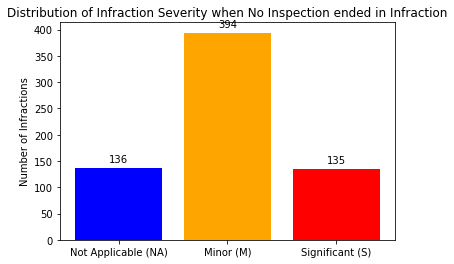

In [34]:
dineSafe_severity = dineSafe_Infraction_NoInspectionList_DF.select('SEVERITY')
dineSafe_severity_labels = dineSafe_severity.distinct()
dineSafe_severity_hist = dineSafe_severity.groupBy('SEVERITY').count()
dineSafe_severity_hist.show()

labels = ['Not Applicable (NA)','Minor (M)','Significant (S)']
counts = [136, 394, 135]

fig, ax = plt.subplots()
rects1 = ax.bar(labels, counts,color=['blue','orange','red','green'])
ax.set_ylabel('Number of Infractions')
ax.set_title('Distribution of Infraction Severity when No Inspection ended in Infraction')
autolabel(rects1)
figsize=(5,5)
plt.show()

Roughly 60% of infractions are considered minor, while 20% are significant, and the remaining 20% are not applicable.

+-------------------+-----+
|           SEVERITY|count|
+-------------------+-----+
|        C - Crucial|  725|
|NA - Not Applicable| 1443|
|          M - Minor|12923|
|    S - Significant| 5043|
+-------------------+-----+



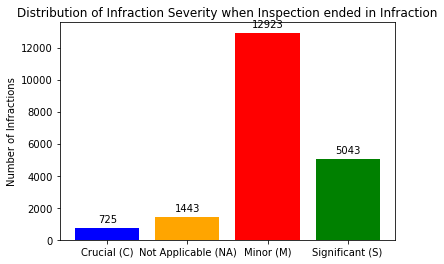

In [35]:
dineSafe_severity = dineSafe_Infraction_Inspectionlist_Infraction_DF.select('SEVERITY')
dineSafe_severity_labels = dineSafe_severity.distinct()
dineSafe_severity_hist = dineSafe_severity.groupBy('SEVERITY').count()
dineSafe_severity_hist.show()

labels = ['Crucial (C)', 'Not Applicable (NA)','Minor (M)','Significant (S)']
counts = [725,1443, 12923, 5043]

fig, ax = plt.subplots()
rects1 = ax.bar(labels, counts,color=['blue','orange','red','green'])
ax.set_ylabel('Number of Infractions')
ax.set_title('Distribution of Infraction Severity when Inspection ended in Infraction')
autolabel(rects1)
figsize=(5,5)
plt.show()

Roughly 65% of infractions are considered minor, while 25% are significant, 7% are not applicable, and the remaining 3% are crucical. 

## Create Final Dinesafe Dataframe

In [36]:
# Analyze Schema of dineSafe
dineSafe_NoInfraction_NoInspectionList_DF.printSchema()
dineSafe_NoInfraction_InspectionList_DF.printSchema()
dineSafe_Infraction_NoInspectionList_DF.printSchema()
dineSafe_Infraction_Inspectionlist_NoInfraction_DF.printSchema()
dineSafe_Infraction_Inspectionlist_Infraction_DF.printSchema()

root
 |-- ds_id: string (nullable = true)
 |-- STATUS: string (nullable = true)
 |-- DATE: string (nullable = true)

root
 |-- ds_id: string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- STATUS: string (nullable = true)

root
 |-- ACTION: string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- SEVERITY: string (nullable = true)
 |-- STATUS: string (nullable = true)
 |-- ds_id: string (nullable = true)

root
 |-- DATE: string (nullable = true)
 |-- STATUS: string (nullable = true)
 |-- ds_id: long (nullable = true)
 |-- pos_ins: string (nullable = true)

root
 |-- ds_id: string (nullable = true)
 |-- pos_ins: integer (nullable = false)
 |-- DATE: string (nullable = true)
 |-- STATUS: string (nullable = true)
 |-- SEVERITY: string (nullable = true)
 |-- ACTION: string (nullable = true)



In [37]:
# Complete columns of datasets so all 5 data sets have the same columns
dineSafe_NoInfraction_NoInspectionList_DF = dineSafe_NoInfraction_NoInspectionList_DF. \
                                                withColumn('pos_ins',lit(None)). \
                                                withColumn('SEVERITY',lit(None)). \
                                                withColumn('ACTION',lit(None)). \
                                                withColumn('ds_subdatabase',lit('dineSafe_NoInfraction_NoInspectionList_DF'))
dineSafe_NoInfraction_NoInspectionList_DF = dineSafe_NoInfraction_NoInspectionList_DF.select("ds_id",'STATUS','DATE','pos_ins','SEVERITY','ACTION','ds_subdatabase')

dineSafe_NoInfraction_InspectionList_DF = dineSafe_NoInfraction_InspectionList_DF. \
                                            withColumn('pos_ins',lit(None)). \
                                            withColumn('SEVERITY',lit(None)). \
                                            withColumn('ACTION',lit(None)). \
                                            withColumn('ds_subdatabase', lit('dineSafe_NoInfraction_InspectionList_DF'))
dineSafe_NoInfraction_InspectionList_DF = dineSafe_NoInfraction_InspectionList_DF.select("ds_id",'STATUS','DATE','pos_ins','SEVERITY','ACTION','ds_subdatabase')

dineSafe_Infraction_NoInspectionList_DF = dineSafe_Infraction_NoInspectionList_DF. \
                                            withColumn('pos_ins',lit(None)). \
                                            withColumn('ds_subdatabase', lit('dineSafe_Infraction_NoInspectionList_DF'))
dineSafe_Infraction_NoInspectionList_DF = dineSafe_Infraction_NoInspectionList_DF.select("ds_id",'STATUS','DATE','pos_ins','SEVERITY','ACTION','ds_subdatabase')

dineSafe_Infraction_Inspectionlist_NoInfraction_DF = dineSafe_Infraction_Inspectionlist_NoInfraction_DF. \
                                                        withColumn('SEVERITY',lit(None)). \
                                                        withColumn('ACTION',lit(None)). \
                                                        withColumn('ds_subdatabase', lit('dineSafe_Infraction_Inspectionlist_NoInfraction_DF'))
dineSafe_Infraction_Inspectionlist_NoInfraction_DF = dineSafe_Infraction_Inspectionlist_NoInfraction_DF.select("ds_id",'STATUS','DATE','pos_ins','SEVERITY','ACTION','ds_subdatabase') 

dineSafe_Infraction_Inspectionlist_Infraction_DF = dineSafe_Infraction_Inspectionlist_Infraction_DF.withColumn('ds_subdatabase', lit('dineSafe_Infraction_Inspectionlist_Infraction_DF'))
dineSafe_Infraction_Inspectionlist_Infraction_DF = dineSafe_Infraction_Inspectionlist_Infraction_DF.select("ds_id",'STATUS','DATE','pos_ins','SEVERITY','ACTION','ds_subdatabase')                                                        

In [38]:
# Verify all data sets have the same columns
dineSafe_NoInfraction_NoInspectionList_DF.printSchema()
dineSafe_NoInfraction_InspectionList_DF.printSchema()
dineSafe_Infraction_NoInspectionList_DF.printSchema()
dineSafe_Infraction_Inspectionlist_NoInfraction_DF.printSchema()
dineSafe_Infraction_Inspectionlist_Infraction_DF.printSchema()

root
 |-- ds_id: string (nullable = true)
 |-- STATUS: string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- pos_ins: null (nullable = true)
 |-- SEVERITY: null (nullable = true)
 |-- ACTION: null (nullable = true)
 |-- ds_subdatabase: string (nullable = false)

root
 |-- ds_id: string (nullable = true)
 |-- STATUS: string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- pos_ins: null (nullable = true)
 |-- SEVERITY: null (nullable = true)
 |-- ACTION: null (nullable = true)
 |-- ds_subdatabase: string (nullable = false)

root
 |-- ds_id: string (nullable = true)
 |-- STATUS: string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- pos_ins: null (nullable = true)
 |-- SEVERITY: string (nullable = true)
 |-- ACTION: string (nullable = true)
 |-- ds_subdatabase: string (nullable = false)

root
 |-- ds_id: long (nullable = true)
 |-- STATUS: string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- pos_ins: string (nullable = true)
 |-- SEVERITY: nul

In [39]:
# Union Infraction dinseSafe datasests
dineSafeInspections = dineSafe_NoInfraction_NoInspectionList_DF. \
                            union(dineSafe_NoInfraction_InspectionList_DF). \
                            union(dineSafe_Infraction_NoInspectionList_DF). \
                            union(dineSafe_Infraction_Inspectionlist_NoInfraction_DF). \
                            union(dineSafe_Infraction_Inspectionlist_Infraction_DF)

# Rename columns
dineSafeInspections = dineSafeInspections.select(
                           col('ds_id').alias('ds_id_ins'),
                           col('pos_ins').alias('ds_pos_ins'),
                           col('DATE').alias('ds_date'),
                           col('STATUS').alias('ds_status_ins'), # there's already a status in original dineSafe
                           col('SEVERITY').alias('ds_severity'),
                           col('ACTION').alias('ds_action'),
                           'ds_subdatabase')

In [40]:
# check structure of inspections dataframe
dineSafeInspections.printSchema()
dineSafeInspections.show(10, truncate=False)
dineSafeInspections.groupBy('ds_status_ins').count().sort("count").show()
print("There are {} rows in the dineSafeInspections dataset".format(dineSafeInspections.count()))

root
 |-- ds_id_ins: string (nullable = true)
 |-- ds_pos_ins: string (nullable = true)
 |-- ds_date: string (nullable = true)
 |-- ds_status_ins: string (nullable = true)
 |-- ds_severity: string (nullable = true)
 |-- ds_action: string (nullable = true)
 |-- ds_subdatabase: string (nullable = false)

+---------+----------+----------+-------------+-----------+---------+-----------------------------------------+
|ds_id_ins|ds_pos_ins|ds_date   |ds_status_ins|ds_severity|ds_action|ds_subdatabase                           |
+---------+----------+----------+-------------+-----------+---------+-----------------------------------------+
|10362913 |null      |2019-12-04|Pass         |null       |null     |dineSafe_NoInfraction_NoInspectionList_DF|
|10196816 |null      |2018-12-27|Pass         |null       |null     |dineSafe_NoInfraction_NoInspectionList_DF|
|10331811 |null      |2019-07-10|Pass         |null       |null     |dineSafe_NoInfraction_NoInspectionList_DF|
|10709846 |null      |20

In [41]:
# Check quality of dineSafeInspections dataset
# COMMENTED: it takes sometime
dineSafeInspections_badRecords = dineSafeInspections.groupBy("ds_date","ds_id_ins",'ds_pos_ins').count().filter("count > 1")

In [42]:
dineSafeInspections_badRecords.count()

0

In [43]:
# Join original dineSafe with dineSafe.inspections data
dineSafeParsed = dineSafe.join(dineSafeInspections, dineSafe.ds_id == dineSafeInspections.ds_id_ins, how='left')

In [44]:
# check structure of final dataframe
dineSafeParsed.printSchema()
dineSafeParsed.show(10)
dineSafeParsed.count()

root
 |-- ds_address: string (nullable = true)
 |-- ds_id: string (nullable = true)
 |-- ds_latitude: double (nullable = true)
 |-- ds_longitude: double (nullable = true)
 |-- ds_name: string (nullable = true)
 |-- ds_status: string (nullable = true)
 |-- ds_type: string (nullable = true)
 |-- ds_inspection: string (nullable = true)
 |-- ds_id_ins: string (nullable = true)
 |-- ds_pos_ins: string (nullable = true)
 |-- ds_date: string (nullable = true)
 |-- ds_status_ins: string (nullable = true)
 |-- ds_severity: string (nullable = true)
 |-- ds_action: string (nullable = true)
 |-- ds_subdatabase: string (nullable = true)

+-----------------+--------+-----------+------------+--------------------+---------+--------------------+--------------------+---------+----------+----------+-------------+-------------------+--------------------+--------------------+
|       ds_address|   ds_id|ds_latitude|ds_longitude|             ds_name|ds_status|             ds_type|       ds_inspection|ds_id_

45628

In [ ]:
# Saving dataset as parquet file
dineSafeParsed.write.option("compression", "gzip").parquet('dineSafeParsed.parquet')

In [ ]:
# Read in parquet file
dineSafeRetrieved = spark.read.parquet('dineSafeParsed.parquet')